# Setup

In [ ]:
# KEY PARAMETERS

image_resolution = 224
B = 32 # batch size, 8 or 32
NUM_HEADS = 2 # number of heads for multi-head attention

## Environment Setup

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import sys
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

## Ensure TensorFlow is not used
import os
os.environ["USE_TF"] = "0"


# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Set project directory to the folder containing the .ipynb and image folders
# project_dir = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Final Project"   # <-- update if your folder name differs
# os.chdir(project_dir)

# print("Using project directory:", os.getcwd())



# Define data directory
DATA_DIR = "cleaned_data"

# Define file paths
TRAIN_DATA_FILE = os.path.join(DATA_DIR, "train.csv")
VALIDATION_DATA_FILE = os.path.join(DATA_DIR, "validation_5k.csv")
TEST_DATA_FILE = os.path.join(DATA_DIR, "test_5k.csv")

# For reproducability
random_state = 42

# Use CPU/MPS if possible
device = None
if "google.colab" in sys.modules:
    # Running in Colab
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    # Not in Colab (e.g., Mac)
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print("Using device:", device)

Using device: mps


## Load Data

In [3]:
TRAIN_DATA = pd.read_csv(TRAIN_DATA_FILE)
VALIDATION_DATA = pd.read_csv(VALIDATION_DATA_FILE, index_col = 0)
TEST_DATA = pd.read_csv(TEST_DATA_FILE, index_col = 0)

In [4]:
# Ignore rows in corrupted_indices.txt files
def filter_out_corrupted_rows(split, DF):
    # File with corrupted indices
    if split == "train":
        corrupted_indices_file = f"{split}_corrupted_indices.txt"
    else:
        corrupted_indices_file = f"{split}_5k_corrupted_indices.txt"

    # Store list of corrupted indices
    corrupted_indices = None

    # Get list of corrupted indices
    with open(corrupted_indices_file, "r") as f:
        corrupted_indices = list(int(line.strip()) for line in f if line.strip())

    print(f"Split: {split}, Corrupted Indices: {corrupted_indices}, Length: {len(corrupted_indices)}")

    # Filter out corrupted rows
    DF = DF.drop(index = corrupted_indices)

    return DF

In [5]:
TRAIN_DATA = filter_out_corrupted_rows("train", TRAIN_DATA)
VALIDATION_DATA = filter_out_corrupted_rows("validation", VALIDATION_DATA)
TEST_DATA = filter_out_corrupted_rows("test", TEST_DATA)

Split: train, Corrupted Indices: [2862, 26040, 28337, 18547, 13374, 11288, 31984, 18451, 19000, 22479, 8048, 32075, 22918, 5586, 19345, 12770, 32189, 14628, 9081, 6611, 2927], Length: 21
Split: validation, Corrupted Indices: [6568, 32176], Length: 2
Split: test, Corrupted Indices: [29133, 9437, 26504, 11394], Length: 4


In [6]:
TRAIN_DATA['image_num'] = TRAIN_DATA.index.astype(str).str.zfill(5)
VALIDATION_DATA['image_num'] = VALIDATION_DATA.index.astype(str).str.zfill(5)
TEST_DATA['image_num'] = TEST_DATA.index.astype(str).str.zfill(5)

In [7]:
TRAIN_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
0,this spongebob squarepants branded battery,2019-07-30 20:00:50,i.redd.it,https://preview.redd.it/f39wxxk8yhd31.jpg?widt...,4.0,33,mildlyinteresting,0.95,1,0,0,00000
1,award for careless talk,2011-09-03 17:26:23,i.imgur.com,https://external-preview.redd.it/KgPHCi1u3fY5j...,1.0,14,propagandaposters,1.00,0,1,5,00001
2,four aligned airplanes,2017-11-20 06:05:45,i.redd.it,https://preview.redd.it/88v9axk19phx.jpg?width...,24.0,198,confusing_perspective,0.98,0,2,2,00002
3,columbus discovers the new world,2019-08-28 15:40:17,i.redd.it,https://preview.redd.it/x4wzpd0am7j31.jpg?widt...,5.0,318,fakehistoryporn,0.98,0,2,2,00003
4,feed me drummmmssssssss,2014-05-09 13:23:59,i.imgur.com,https://external-preview.redd.it/yNN57loQnVhLk...,0.0,3,pareidolia,0.62,0,2,2,00004


In [8]:
VALIDATION_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
8637,not as heartwarming as it could have been anth...,2019-09-19 17:48:33,lifestyle.clickhole.com,https://external-preview.redd.it/850kBbKdgMKfz...,0.0,15,theonion,0.86,0,2,1,08637
20669,other discussions,2013-12-09 23:58:43,NaN,http://i.dailymail.co.uk/i/pix/2013/12/09/arti...,NaN,0,psbattle_artwork,NaN,0,2,4,20669
13179,on reflection oc,2015-01-12 17:14:55,i.imgur.com,https://external-preview.redd.it/tiFw8Ggb178E4...,0.0,3,pareidolia,0.67,0,2,2,13179
20565,viet congo setting booby trap,2019-02-27 09:57:07,i.redd.it,https://preview.redd.it/mj81gkh533j21.jpg?widt...,4.0,14,fakehistoryporn,0.80,0,2,2,20565
15504,chief has some happy shoulder armour,2013-02-20 01:00:02,i.imgur.com,https://external-preview.redd.it/kqqIlnAOZxzxA...,0.0,6,pareidolia,1.00,0,2,2,15504


In [9]:
TEST_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
19660,young homosexuals gather outside of a nightclu...,2018-07-29 13:59:38,i.redd.it,https://preview.redd.it/16j830998wc11.jpg?widt...,1.0,75,fakehistoryporn,0.92,0,2,2,19660
32879,cara al sol facing the sun a series of posters...,2013-05-20 18:25:00,imgur.com,https://external-preview.redd.it/S_nXt5X8VMqZD...,4.0,19,propagandaposters,0.89,0,1,5,32879
15071,he is awake and rises from the depths,2013-10-13 20:02:17,imgur.com,https://external-preview.redd.it/JetvyFQFm4fYt...,0.0,7,pareidolia,0.99,0,2,2,15071
5198,the reason germany invades france and not spain,2018-09-03 08:22:07,i.redd.it,https://preview.redd.it/ws91cs7lgzj11.png?widt...,0.0,57,fakehistoryporn,0.97,0,2,2,05198
15061,frozen body preserved on mount everest nsfw,2017-09-12 08:10:21,i.redd.it,https://preview.redd.it/zxwc8gq8uelz.jpg?width...,0.0,24,fakehistoryporn,1.00,0,2,2,15061


## Create News Dataset and DataLoader

In [10]:
class RedditDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Fetch text
        text = row['clean_title']

        # Get image number
        image_num = row['image_num']

        # Fetch Image
        img_path = os.path.join(self.image_dir, f"{image_num}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Label
        label = torch.tensor(row['2_way_label'], dtype=torch.long)

        return text, image, label

In [11]:
train_tfms = transforms.Compose([
    transforms.Resize((image_resolution, image_resolution)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_tfms = transforms.Compose([
    transforms.Resize((image_resolution, image_resolution)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [12]:
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.stack(labels)
    return list(texts), images, labels

In [13]:
train_dataset = RedditDataset(
    df = TRAIN_DATA,
    image_dir = "train_images",
    transform = train_tfms
)

validation_dataset = RedditDataset(
    df = VALIDATION_DATA,
    image_dir = "validation_images",
    transform = val_test_tfms
)

test_dataset = RedditDataset(
    df = TEST_DATA,
    image_dir = "test_images",
    transform = val_test_tfms
)

In [14]:
train_loader = DataLoader(
    train_dataset,
    batch_size=B,
    shuffle=True,
    collate_fn=collate_fn
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

In [15]:
## Sanity Check
texts, imgs, labels = next(iter(train_loader)) # try with validation_loader too
print("Number of texts:", len(texts))
print("Example text:", texts[0])
print("Images shape:", imgs.shape)      # (B, 3, 224, 224)
print("Labels shape:", labels.shape)
print("Labels:", labels)

Number of texts: 8
Example text: mailbox ghillie suit
Images shape: torch.Size([8, 3, 224, 224])
Labels shape: torch.Size([8])
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 1])


## Set up Fake News Detection (FND) CLIP Model

In [16]:
## Ensure TensorFlow is not used
import os
os.environ["USE_TF"] = "0"

# Import necessary software
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models as tv_models
from transformers import CLIPModel, BertModel, BertTokenizer, CLIPTokenizer

# Use CPU/MPS if possible
import sys
device = None
if "google.colab" in sys.modules:
    # Running in Colab
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    # Not in Colab (e.g., Mac)
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print("Using device:", device)

# Projection Head: 2-layer MLP (Reference: Page 4, Figure 2 of Paper)
class ProjectionHead(nn.Module):
    # in_dim: Number of input features to the Projection Head
    # hidden_dim: Size of hidden state representation
    # out_dim: Size of output dimension
    # dropout: dropout rate
    def __init__(self, in_dim, hidden_dim=256, out_dim=64, dropout=0.2):
        super().__init__()

        # Sequence 1: FC -> BN -> ReLU
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()

        # Define Dropout 
        self.dropout = nn.Dropout(dropout)

        # Sequence 2: FC -> BN -> ReLU
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)

    # Input Shape: (B, D) where B is batch size and D is in_dim
    def forward(self, x):
        # Sequence 1: FC -> BN -> ReLU
        x = self.fc1(x) # Shape: B x hidden_dim
        x = self.relu(x) # Shape: B x hidden_dim
        x = self.bn1(x) # Shape: B x hidden_dim

        # Dropout
        x = self.dropout(x) # Shape: B x hidden_dim

        # Sequence 2: FC -> BN -> ReLU
        x = self.fc2(x) # Shape: B x out_dim
        x = self.relu(x) # Shape: B x out_dim
        x = self.bn2(x) # Shape: B x out_dim

        # Return Output
        return x # Shape: B x out_dim

class QKVAttention(nn.Module):
    def __init__(self, feat_dim, num_heads=1, qkv_dim=16):
        super().__init__()

        self.feat_dim = feat_dim
        self.qkv_dim = qkv_dim
        self.num_heads = num_heads

        # Project 64 to 16
        self.q_proj = nn.Linear(feat_dim, qkv_dim)
        self.k_proj = nn.Linear(feat_dim, qkv_dim)
        self.v_proj = nn.Linear(feat_dim, qkv_dim)

        # Multihead attention in reduced dimension
        self.attn = nn.MultiheadAttention(
            embed_dim=qkv_dim,
            num_heads=num_heads,
            batch_first=True
        )

        # Project back to feat_dim (64)
        self.out_proj = nn.Linear(qkv_dim, feat_dim)

    def forward(self, m_txt, m_img, m_mix):
        # Stack modalities (B, 3, feat_dim)
        x = torch.stack([m_txt, m_img, m_mix], dim=1)

        # Linear projections (B, 3, qkv_dim)
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # Attention in reduced space
        out, _ = self.attn(Q, K, V)   # (B, 3, qkv_dim)

        # Mean-pool to fuse modalities
        mAgg = out.mean(dim=1)  # (B, qkv_dim)

        # Project back to feat_dim (64)
        return self.out_proj(mAgg)

# Define Final Classification Head
class ClassificationHead(nn.Module):
    # in_dim: Number of input features to the Classification Head
    # hidden_dim: Size of hidden state representation
    # out_dim: Size of output dimension
    def __init__(self, in_dim, hidden_dim = 64, out_dim = 2):
        super().__init__()

        # Sequence 1: FC -> ReLU
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Sequence 2: FC
        self.fc2 = nn.Linear(hidden_dim, out_dim)
    
    # Shape of x: B(batch size) x d(# of features)
    def forward(self, x):
        # Pass through first layer
        x = self.relu(self.fc1(x))

        # Pass through second layer
        x = self.fc2(x)

        # Return output
        return x

# Fake News Detection(FND) CLIP Model
class FND_CLIP(nn.Module):
    # resnet_model_name: Name of resnet model
    # clip_model_name: Name of CLIP model
    # bert_model_name: Name of BERT Model
    def __init__(
        self,
        resnet_model_name = "resnet101",
        clip_model_name='openai/clip-vit-base-patch32',
        bert_model_name='bert-base-uncased',
        proj_hidden=256,
        proj_out=64,
        classifier_hidden=64,
        dropout=0.2,
        momentum=0.1
    ):
        super().__init__()

        # Sanity Check
        assert resnet_model_name == "resnet101"

        # 1. Setup ResNet Image Encoder
        # Replace the final fully connected layer with Identity because we only need the ResNet feature embeddings.
        self.image_encoder = tv_models.resnet101(weights='IMAGENET1K_V1')
        self.image_encoder.fc = nn.Identity()

        # Sanity Check: Assert that ResNet parameters are going to be fine tuned
        for param in self.image_encoder.parameters():
            assert param.requires_grad == True

        # 2. Setup BERT Text Encoder
        self.text_encoder = BertModel.from_pretrained(bert_model_name)
        self.text_encoder_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

        # Freeze BERT weights
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # 3. Setup Multimodal (Text + Image) Encoder
        self.multimodal_encoder = CLIPModel.from_pretrained(clip_model_name)
        self.multimodal_encoder_tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)

        # Freeze CLIP weights
        for param in self.multimodal_encoder.parameters():
            param.requires_grad = False

        # 4. Set up Text Projection Head
        self.pTxt = ProjectionHead(in_dim = 1280, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)
        self.pImg = ProjectionHead(in_dim = 2560, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)
        self.pMix = ProjectionHead(in_dim = 1024, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)

        # 5. Set up Modality-Wise Attention
        self.attention = QKVAttention(feat_dim = proj_out, num_heads = NUM_HEADS)

        # 6. Set up Final Classification Head
        self.classification_head = ClassificationHead(in_dim = proj_out, hidden_dim = classifier_hidden, out_dim = 2)

        # Set up Running Buffers
        self.momentum = momentum
        self.eps = 1e-8
        self.register_buffer("running_mean", torch.tensor(0.0, device=device))
        self.register_buffer("running_var", torch.tensor(1.0, device=device))

    # Shape: fCLIP_T (B, 512)
    # Shape: fCLIP_I (B, 512)
    def compute_multimodal_features(self, fCLIP_T, fCLIP_I):
        sim = F.cosine_similarity(fCLIP_T, fCLIP_I) # Compute cosine similarity, Shape: (B, )
        fMix = torch.cat((fCLIP_T, fCLIP_I), dim = 1) # Shape: (B, 512 + 512 = 1024)

        if self.training:
            batch_mean = sim.mean() # Mean
            batch_var = sim.var() # Variance

            # update running stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

            mean, var = batch_mean, batch_var
        else:
            # use running stats for eval
            mean, var = self.running_mean, self.running_var

        # standardize similarity
        sim_std = (sim - mean) / torch.sqrt(var + self.eps)

        # weight multimodal features
        sim_weight = torch.sigmoid(sim_std).unsqueeze(1) # Shape: (B, 1)

        mMix = sim_weight * self.pMix(fMix) # Shape: (B, 64)

        # Return fMix and mMix
        return fMix, mMix

    # txt(B, ), List of Text Strings
    # img(B, C_in = 3, H_in = 224, W_in = 224), List of Corresponding Imagess
    def forward(self, txt, img):
        # Compute BERT Text Features
        text_encoding = self.text_encoder_tokenizer(
            txt,
            padding='max_length',
            truncation=True,
            max_length = self.text_encoder_tokenizer.model_max_length,
            return_tensors="pt"
        ).to(device) # Tokenize text

        fBERT = self.text_encoder(**text_encoding).last_hidden_state[:, 0, :] # Use [CLS] token as text feature
        # Shape: (B, 768)

        # Compute ResNet Image Features
        fResNet = self.image_encoder(img) # Output Shape: (B, 2048)

        # Compute CLIP Text and Image Features
        text_encoding = self.multimodal_encoder_tokenizer(
            txt,
            padding='max_length',
            truncation=True,
            max_length = self.multimodal_encoder_tokenizer.model_max_length,
            return_tensors="pt"
        ).to(device) # Tokenize text

        fCLIP_T = self.multimodal_encoder.get_text_features(**text_encoding) # Compute CLIP Text Features
        fCLIP_I = self.multimodal_encoder.get_image_features(img) # Compute CLIP Image Features

        # Concatenate
        fTxt = torch.cat((fBERT, fCLIP_T), dim = 1) # Shape: (B, 768 + 512 = 1280)
        fImg = torch.cat((fResNet, fCLIP_I), dim = 1) # Shape: (B, 2048 + 512 = 2560)

        # Compute mTxt and mImg
        mTxt = self.pTxt(fTxt) # Shape: (B, 64)
        mImg = self.pImg(fImg) # Shape: (B, 64)

        fMix, mMix = self.compute_multimodal_features(fCLIP_T, fCLIP_I)
        # fMix Shape: (B, 512 + 512 = 1024)
        # mMix Shape: (B, 64)

        # Perform Modality-Wise Attention
        mAgg = self.attention(mTxt, mImg, mMix) # Shape: (B, 64)

        # Compute Final Logits
        logits = self.classification_head(mAgg) # Shape: (B, 2)
        return logits

Using device: mps


In [17]:
model = FND_CLIP().to(device)

# Training

In [18]:
# Compute Class Proportions
p0 = (TRAIN_DATA['2_way_label'] == 0).mean() # Computes the percentage of our training dataset that has label = 0 [Fake News]
p1 = (TRAIN_DATA['2_way_label'] == 1).mean() # Computes the percentage of our training dataset that has label = 1 [Non-Fake News]
print(f"{p0  * 100}% of our dataset has label = 0 and {p1  * 100}% of our dataset has label = 1")

44.62961294778248% of our dataset has label = 0 and 55.37038705221752% of our dataset has label = 1


In [19]:
# Define Weighted Loss Criterion
class_weights = torch.tensor([p1, p0]).float().to(device)
custom_criterion = nn.CrossEntropyLoss(weight = class_weights)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([0.5537, 0.4463], device='mps:0')


In [20]:
# Define Adam Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    model = model.to(device)
    best_acc=0.0
    save_dir = "Milestone_4"

    # --- simple bookkeeping lists ---
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    update = 0  # global update counter

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)
        model.train()
        for batch_idx, (txts, imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            # ----- forward + backward -----
            optimizer.zero_grad()
            outputs = model(txts, imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # ----- training metrics -----
            _, preds = outputs.max(1)
            correct = (preds == labels).sum().item()
            total = labels.size(0)

            train_losses.append(loss.item())
            train_accuracies.append(correct / total)

            print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {train_losses[-1]}, Acc: {train_accuracies[-1]}")

            update += 1



            # ----- every 100 updates: run validation + save -----
            if update % 100 == 0 or update == 1:
                model.eval()
                v_correct = 0
                v_total = 0
                v_loss_total = 0.0

                with torch.no_grad():
                    for v_txts, v_imgs, v_labels in val_loader:
                        v_imgs, v_labels = v_imgs.to(device), v_labels.to(device)
                        v_outputs = model(v_txts, v_imgs)
                        v_loss = criterion(v_outputs, v_labels)

                        _, v_preds = v_outputs.max(1)
                        v_correct += (v_preds == v_labels).sum().item()
                        v_total += v_labels.size(0)
                        v_loss_total += v_loss.item() * v_labels.size(0)

                val_accuracy = v_correct / v_total
                val_loss = v_loss_total / v_total


                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)

                # save BEST model across all training
                if val_accuracy > best_acc:
                    best_acc = val_accuracy
                    torch.save(model.state_dict(), f"{save_dir}/best_model_QKV.pt")

                # save LATEST model
                torch.save(model.state_dict(), f"{save_dir}/latest_model_QKV.pt")

                # bookkeeping
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

                # print everything
                print(
                    f"[Update {update}] "
                    f"Train Loss: {loss.item():.4f}, Train Acc: {correct/total:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
                )

                # Put model back in training mode
                model.train()



    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    torch.save(model.state_dict(), f"{save_dir}/latest_model_QKV.pt")
    return train_losses, train_accuracies, val_losses, val_accuracies

In [22]:
import gc
gc.collect()
torch.cuda.empty_cache() # clear CUDA cache before training

train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, validation_loader, custom_criterion, optimizer, epochs=3
)

Epoch 1/3
----------
Batch 1/4163, Loss: 0.6559937596321106, Acc: 0.625


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Update 1] Train Loss: 0.6560, Train Acc: 0.6250 | Val Loss: 0.7133, Val Acc: 0.4456
Batch 2/4163, Loss: 0.820875883102417, Acc: 0.0
Batch 3/4163, Loss: 0.6582192182540894, Acc: 0.625
Batch 4/4163, Loss: 0.7164537310600281, Acc: 0.375
Batch 5/4163, Loss: 0.6842252612113953, Acc: 0.5
Batch 6/4163, Loss: 0.655393660068512, Acc: 0.625
Batch 7/4163, Loss: 0.7431371212005615, Acc: 0.25
Batch 8/4163, Loss: 0.7880041003227234, Acc: 0.125
Batch 9/4163, Loss: 0.6561534404754639, Acc: 0.625
Batch 10/4163, Loss: 0.7145928740501404, Acc: 0.375
Batch 11/4163, Loss: 0.7174097299575806, Acc: 0.375
Batch 12/4163, Loss: 0.6624692678451538, Acc: 0.625
Batch 13/4163, Loss: 0.7531691193580627, Acc: 0.25
Batch 14/4163, Loss: 0.7149847149848938, Acc: 0.375
Batch 15/4163, Loss: 0.6893966197967529, Acc: 0.5
Batch 16/4163, Loss: 0.6588908433914185, Acc: 0.625
Batch 17/4163, Loss: 0.664567232131958, Acc: 0.625
Batch 18/4163, Loss: 0.75007164478302, Acc: 0.25
Batch 19/4163, Loss: 0.6781594157218933, Acc: 0.5
Bat

# Evaluation

In [23]:
## Load in saved loss and accuracy values

# step_df = pd.read_csv("step_losses.csv")
# update_df = pd.read_csv("update_losses.csv")

# train_losses = step_df["train_loss"].to_numpy()
# train_accs = step_df["train_accuracy"].to_numpy()

# val_losses = update_df["val_loss"].to_numpy()
# val_accs = update_df["val_acc"].to_numpy()

In [24]:
import pickle

with open("CLIP_QKV_metrics.pkl", "wb") as f:
    pickle.dump({
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs
    }, f)

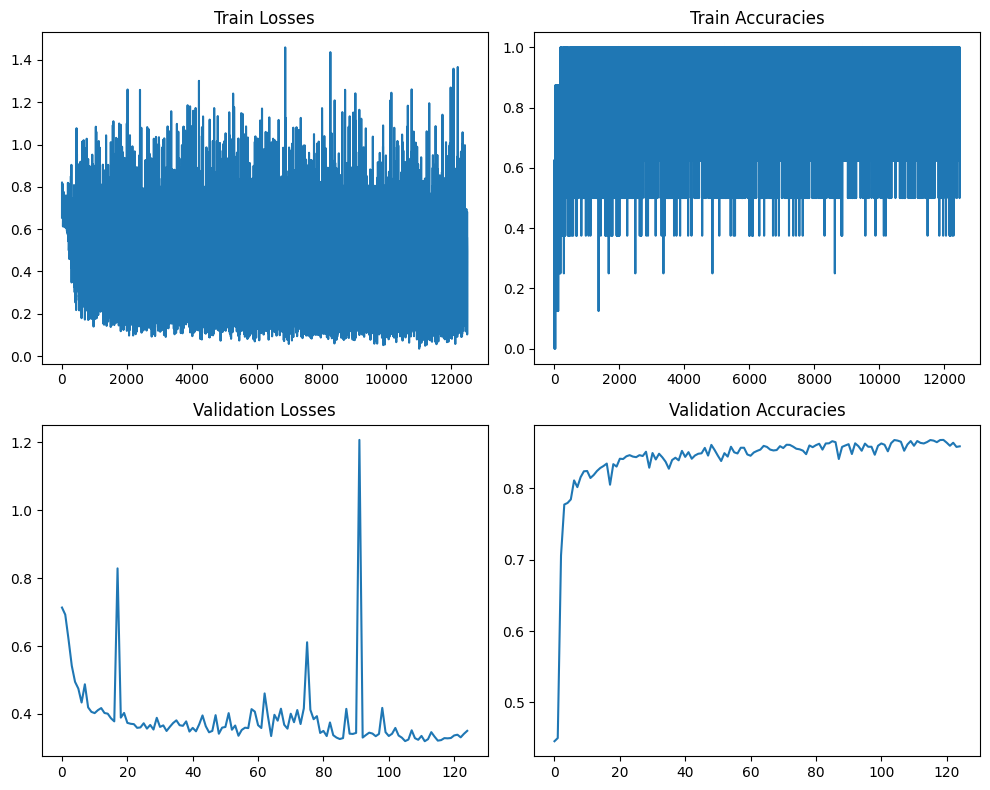

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Train Losses")

axs[0, 1].plot(train_accs)
axs[0, 1].set_title("Train Accuracies")

axs[1, 0].plot(val_losses)
axs[1, 0].set_title("Validation Losses")

axs[1, 1].plot(val_accs)
axs[1, 1].set_title("Validation Accuracies")

plt.tight_layout()
plt.show()


In [26]:
print(f"Final Val Accuracy: {val_accs[-1]}")

Final Val Accuracy: 0.8591436574629852


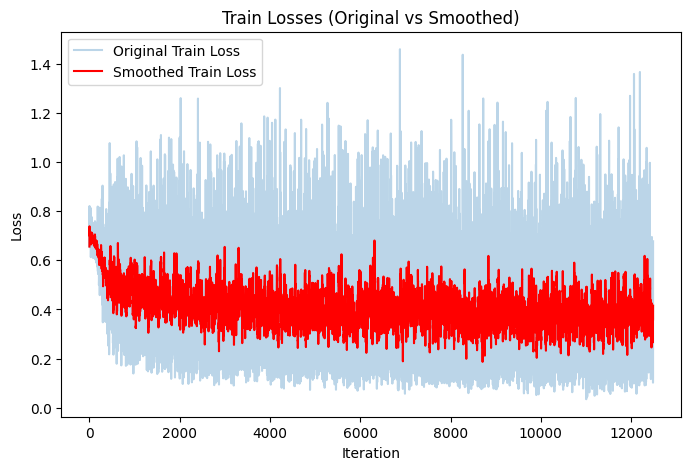

In [27]:
# Smooth the train losses
window = 10
smooth_train_losses = pd.Series(train_losses).rolling(window=window, min_periods=1).mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_losses, alpha=0.3, label="Original Train Loss")
plt.plot(smooth_train_losses, color='red', label="Smoothed Train Loss")
plt.title("Train Losses (Original vs Smoothed)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(logits, labels):
    logits = np.array(logits)
    labels = np.array(labels)
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),

        "pos_precision": precision_score(labels, predictions, pos_label=1, average="binary", zero_division=0),
        "pos_recall": recall_score(labels, predictions, pos_label=1, average="binary", zero_division=0),
        "pos_f1": f1_score(labels, predictions, pos_label=1, average="binary", zero_division=0),

        "neg_precision": precision_score(labels, predictions, pos_label=0, average="binary", zero_division=0),
        "neg_recall": recall_score(labels, predictions, pos_label=0, average="binary", zero_division=0),
        "neg_f1": f1_score(labels, predictions, pos_label=0, average="binary", zero_division=0),

        "f1_macro": f1_score(labels, predictions, average="macro"),
        "f1_micro": f1_score(labels, predictions, average="micro"),
        "f1_weighted": f1_score(labels, predictions, average="weighted"),
    }

In [29]:
def evaluate_model(model, dataloader):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for txts, imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(txts, imgs)      # logits
            all_logits.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return compute_metrics(all_logits, all_labels)



def print_metrics(name, metrics):
    print(f"\n===== {name} Metrics =====")
    for k, v in metrics.items():
        print(f"{k:15s} : {v:.4f}")


In [30]:
# Load best checkpoint before evaluation
model.load_state_dict(torch.load("Milestone_4/best_model_QKV.pt", map_location=device))
model.to(device)
model.eval()



# Evaluate
train_metrics = evaluate_model(model, train_loader)
val_metrics   = evaluate_model(model, validation_loader)
test_metrics  = evaluate_model(model, test_loader)

print_metrics("TRAIN", train_metrics)
print_metrics("VALIDATION", val_metrics)
print_metrics("TEST", test_metrics)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



===== TRAIN Metrics =====
accuracy        : 0.8804
pos_precision   : 0.8753
pos_recall      : 0.9142
pos_f1          : 0.8943
neg_precision   : 0.8873
neg_recall      : 0.8384
neg_f1          : 0.8622
f1_macro        : 0.8782
f1_micro        : 0.8804
f1_weighted     : 0.8800

===== VALIDATION Metrics =====
accuracy        : 0.8681
pos_precision   : 0.8682
pos_recall      : 0.8986
pos_f1          : 0.8831
neg_precision   : 0.8681
neg_recall      : 0.8303
neg_f1          : 0.8487
f1_macro        : 0.8659
f1_micro        : 0.8681
f1_weighted     : 0.8678

===== TEST Metrics =====
accuracy        : 0.8593
pos_precision   : 0.8664
pos_recall      : 0.8830
pos_f1          : 0.8746
neg_precision   : 0.8500
neg_recall      : 0.8297
neg_f1          : 0.8397
f1_macro        : 0.8572
f1_micro        : 0.8593
f1_weighted     : 0.8591


In [31]:
# Save
pd.DataFrame([train_metrics]).to_csv("FND_CLIP_QKV_train_metrics.csv", index=False)
pd.DataFrame([val_metrics]).to_csv("FND_CLIP_QKV_val_metrics.csv", index=False)
pd.DataFrame([test_metrics]).to_csv("FND_CLIP_QKV_test_metrics.csv", index=False)